In [1]:
%pip install librosa
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import librosa

In [33]:
import pandas as pd
metadata = pd.read_csv('./voices_dataset/speakers_all.csv')
metadata.tail(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,native_class,patientId,Unnamed: 11
314,22.0,10.0,"hardinxveld-giessendam, netherlands",dutch39,dutch,female,1482,netherlands,False,False,ivan62,NaN
315,18.0,10.0,"bilzen, flanders, belgium",dutch4,dutch,male,743,belgium,False,False,ivan64,NaN
316,25.0,9.0,"dordrecht, netherlands",dutch40,dutch,male,1484,netherlands,False,False,ivan64,NaN
317,41.0,13.0,"deventer, netherlands",dutch41,dutch,male,1517,netherlands,False,False,ivan64,NaN
318,36.0,8.0,"schiedam, netherlands",dutch42,dutch,male,1551,netherlands,False,False,ivan64,NaN
319,21.0,11.0,"rotterdam, netherlands",dutch43,dutch,male,1705,netherlands,False,False,ivan64,NaN
320,21.0,12.0,"antwerp, belgium",dutch44,dutch,female,1740,belgium,False,False,ivan64,NaN
321,22.0,2.0,"sint niklaas, belgium",dutch45,dutch,male,1742,belgium,False,False,ivan64,NaN
322,22.0,12.0,"hulshout, belgium",dutch46,dutch,female,1743,belgium,False,False,ivan64,NaN
323,37.0,11.0,"gouda, netherlands",dutch47,dutch,female,2115,netherlands,False,False,ivan64,NaN


In [71]:
metadata['sex'].value_counts

<bound method IndexOpsMixin.value_counts of 0      female
1        male
2        male
3        male
4        male
        ...  
319      male
320    female
321      male
322    female
323    female
Name: sex, Length: 324, dtype: object>

In [35]:
from scipy.io import wavfile as wav
audio_file_path = './voices_dataset/recordings_wav/afrikaans1-gain.wav'
wave_sample_rate, wave_audio = wav.read(audio_file_path)
wave_audio

array([297, 361, 289, ..., -43, -44, -30], dtype=int16)

In [36]:
## Extracting MFCC'S for every audio file
audio_dataset_path = './voices_dataset/recordings_wav/'

In [37]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [38]:
import numpy as np
import os
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["filename"]) + str('-gain.wav'))
    final_class_labels=row["patientId"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

324it [02:03,  2.63it/s]


In [39]:
### converting extracted_features to pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'patientId'])

In [40]:
## Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['patientId'].tolist())

In [41]:
X.shape

(324, 128)

In [42]:
### Label encoding
y = np.array(pd.get_dummies(y))

In [43]:
### Train Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)

In [44]:
X_train.shape

(32, 128)

In [45]:
X_test.shape

(292, 128)

In [46]:
y_train.shape

(32, 33)

In [47]:
y_test.shape

(292, 33)

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [72]:
## number of patietsId
num_labels = y.shape[1]
num_labels

33

In [73]:
model = Sequential()
### first layer
model.add(Dense(200, input_shape=(128,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
### second layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
### third layer
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
### final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 200)               25800     
                                                                 
 activation_10 (Activation)  (None, 200)               0         
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 100)               20100     
                                                                 
 activation_11 (Activation)  (None, 100)               0         
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 50)               

In [75]:
model.compile(
  loss='categorical_crossentropy',
  metrics=['accuracy', 'mae', 'mse'],
  optimizer='adam'
)

In [98]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 50
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(
  X_train,
  y_train,
  batch_size=num_batch_size,
  epochs=num_epochs,
  validation_data=(X_test, y_test),
  callbacks=[checkpointer],
  verbose=1,
  validation_split = 0.2
)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 3.1830 - accuracy: 0.0400 - mae: 0.0580 - mse: 0.0287
Epoch 1: val_loss improved from inf to 3.39397, saving model to saved_models/audio_classification.hdf5
1/1 [==============================] - 0s 81ms/step - loss: 3.1830 - accuracy: 0.0400 - mae: 0.0580 - mse: 0.0287 - val_loss: 3.3940 - val_accuracy: 0.1429 - val_mae: 0.0585 - val_mse: 0.0292
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 3.2437 - accuracy: 0.0400 - mae: 0.0581 - mse: 0.0293
Epoch 2: val_loss improved from 3.39397 to 3.39389, saving model to saved_models/audio_classification.hdf5
1/1 [==============================] - 0s 55ms/step - loss: 3.2437 - accuracy: 0.0400 - mae: 0.0581 - mse: 0.0293 - val_loss: 3.3939 - val_accuracy: 0.1429 - val_mae: 0.0585 - val_mse: 0.0292
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 3.2159 - accuracy: 0.1200 - mae: 0.0581 - mse: 0.0289
Epoch 3: val_loss improved from 3.39389 to 3.3

In [99]:
test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_accuracy

[3.577434778213501,
 0.02397260256111622,
 0.05879722163081169,
 0.02952713891863823]

In [100]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse,epoch
45,3.232243,0.04,0.058130,0.029084,3.390629,0.142857,0.058507,0.029235,45
46,3.258854,0.04,0.058237,0.029094,3.390570,0.142857,0.058506,0.029235,46
47,3.011408,0.20,0.056690,0.027749,3.390509,0.142857,0.058506,0.029235,47
48,3.157231,0.12,0.057105,0.028336,3.390454,0.142857,0.058506,0.029235,48
49,3.144669,0.12,0.057616,0.028495,3.390399,0.142857,0.058505,0.029235,49


In [101]:
def plot_history(history):     
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mse'],'b',
           label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

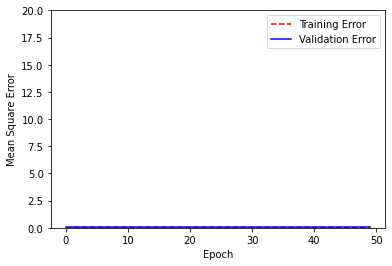

In [102]:
plot_history(history)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 3.1623 - accuracy: 0.0400 - mae: 0.0579 - mse: 0.0290
Epoch 1: val_loss improved from 3.39040 to 3.39034, saving model to saved_models/audio_classification.hdf5
1/1 [==============================] - 0s 80ms/step - loss: 3.1623 - accuracy: 0.0400 - mae: 0.0579 - mse: 0.0290 - val_loss: 3.3903 - val_accuracy: 0.1429 - val_mae: 0.0585 - val_mse: 0.0292
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 3.2733 - accuracy: 0.0800 - mae: 0.0581 - mse: 0.0291
Epoch 2: val_loss improved from 3.39034 to 3.39029, saving model to saved_models/audio_classification.hdf5
1/1 [==============================] - 0s 52ms/step - loss: 3.2733 - accuracy: 0.0800 - mae: 0.0581 - mse: 0.0291 - val_loss: 3.3903 - val_accuracy: 0.1429 - val_mae: 0.0585 - val_mse: 0.0292
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 3.2609 - accuracy: 0.0400 - mae: 0.0582 - mse: 0.0297
Epoch 3: val_loss improved from 3.39029 to

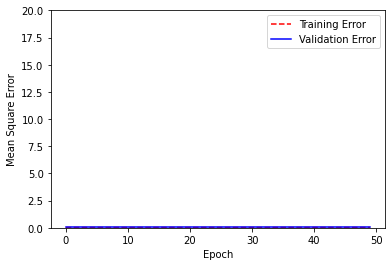

In [103]:
early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10)

history = model.fit(
  X_train,
  y_train,
  batch_size=num_batch_size,
  epochs=num_epochs,
  validation_data=(X_test, y_test),
  callbacks=[checkpointer, early_stop],
  verbose=1,
  validation_split = 0.2
)

plot_history(history)

In [104]:
### testing the model
test_filename = './voices_dataset/recordings_wav/afrikaans1-gain.wav'
audio, sample_rate = librosa.load(test_filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
# print(mfccs_scaled_features)

# using juts one item
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)
#print(mfccs_scaled_features)
#print(mfccs_scaled_features.shape)

predicted_label = model.predict(mfccs_scaled_features)
predicted_classes = np.argmax(predicted_label, axis=1)
predicted_classes

array([21])

In [105]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(metadata['patientId']))

prediction_class = labelencoder.inverse_transform(predicted_classes)
prediction_class

array(['ivan48'], dtype=object)

In [106]:
metadata.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,native_class,patientId,Unnamed: 11
0,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,True,ivan1,NaN
1,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,True,ivan1,NaN
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,True,ivan1,NaN
3,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,True,ivan1,NaN
4,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,True,ivan1,NaN
5,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,3,ivory coast,False,True,ivan1,NaN
6,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana,False,True,ivan1,NaN
7,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo,False,True,ivan1,NaN
8,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania,False,True,ivan1,NaN
9,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania,False,True,ivan1,NaN


In [107]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

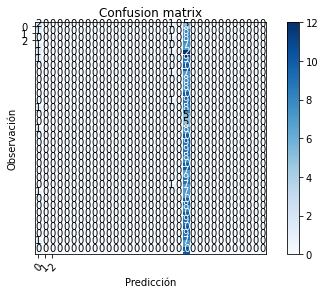

In [108]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))